In [1]:
import numpy as np
import scipy

In [130]:
N = 5
w = 1
k = 1/0.129
n_th = 0.063

a = np.zeros((N, N))
for n in range(1, N):
    a[n-1, n] = np.sqrt(n)
a_dag = np.zeros((N, N))
for n in range(N-1):
    a_dag[n+1, n] = np.sqrt(n+1)

H = w * a_dag @ a

In [131]:
c_ops = []

c_ops.append(np.sqrt(k * (1 + n_th)) * a)
c_ops.append(np.sqrt(k * n_th) * a_dag)

psi0 = np.zeros(N)
psi0[1] = 1

In [116]:
def integrate(H, dt, psi0):
    psi = psi0
    psi = scipy.linalg.expm(-1j * H * dt) @ psi
    return psi

In [117]:
def determine_jump(c_ops, psi, r2):
    jump = None
    p_tot = sum([np.linalg.norm(c_op @ psi) ** 2 for c_op in c_ops])
    p_it = 0
    for c_op in c_ops:
        prob = np.linalg.norm(c_op @ psi) ** 2
        p_it += prob / p_tot
        if p_it >= r2:
            jump = c_op
            break
    return jump

In [135]:
def montecarlo(H, c_ops, psi0, tlist):
    H_eff = H - 1j * sum([c.conj().T @ c for c in c_ops]) / 2

    dt = (max(tlist) - min(tlist)) / len(tlist)
    psi = psi0 / np.linalg.norm(psi0)
    psi_j = []
    psi_j.append(psi)

    r1 = np.random.rand()
    r2 = np.random.rand()
    for t_e in tlist:
        psi = integrate(H_eff, dt, psi)

        if np.linalg.norm(psi) ** 2 <= r1:
            jump = determine_jump(c_ops, psi, r2)
            psi = jump @ psi / np.linalg.norm(jump @ psi)
            r1 = np.random.rand()
            r2 = np.random.rand()

        psi_j.append(psi)

    psi_j.pop()
    return psi_j

In [140]:
times = np.linspace(0, 8, 10000)
result = montecarlo(H, c_ops, psi0, times)
N_evolution = [np.linalg.norm(a @ psi) ** 2 / np.linalg.norm(psi) ** 2 for psi in result]

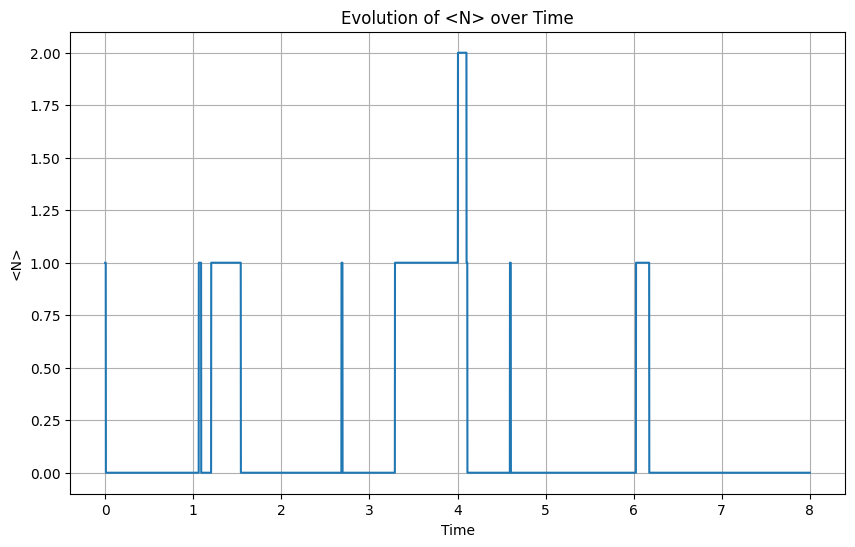

In [141]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, N_evolution)
plt.xlabel('Time')
plt.ylabel('<N>')
plt.title('Evolution of <N> over Time')
plt.grid(True)
plt.show()

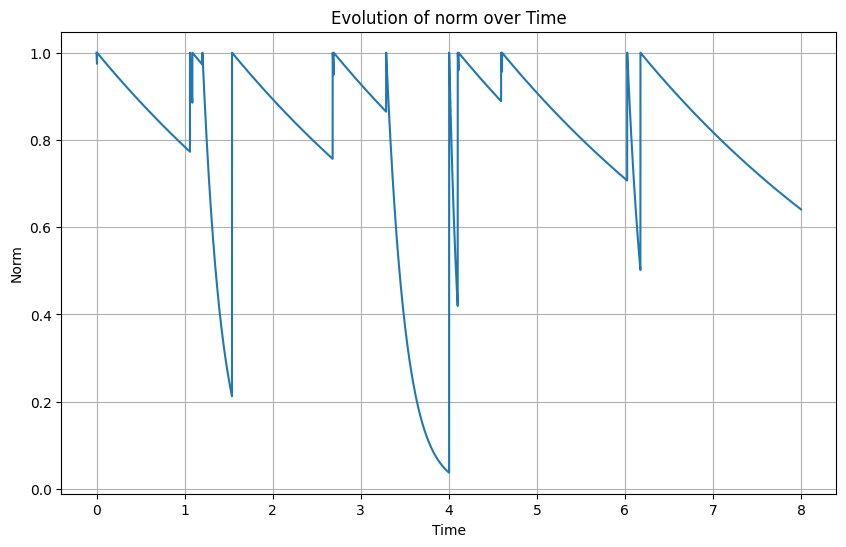

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(times, [np.linalg.norm(psi) for psi in result])
plt.xlabel("Time")
plt.ylabel("Norm")
plt.title("Evolution of norm over Time")
plt.grid(True)
plt.show()

In [143]:
def montecarlo_average(H, c_ops, psi0, tlist, ntraj, op):
    results = []
    for i in range(ntraj):
        results.append(montecarlo(H, c_ops, psi0, tlist))
    for i in range(len(results)):
        results[i] = [psi.conj().T @ op @ psi / np.linalg.norm(psi) ** 2 for psi in results[i]]
    results = np.mean(results, axis=0)

    return results

In [ ]:
times = np.linspace(0, 0.8, 1000)
result = montecarlo_average(H, c_ops, psi0, times, 200, a_dag @ a)

C:\Users\Pietro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Pietro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


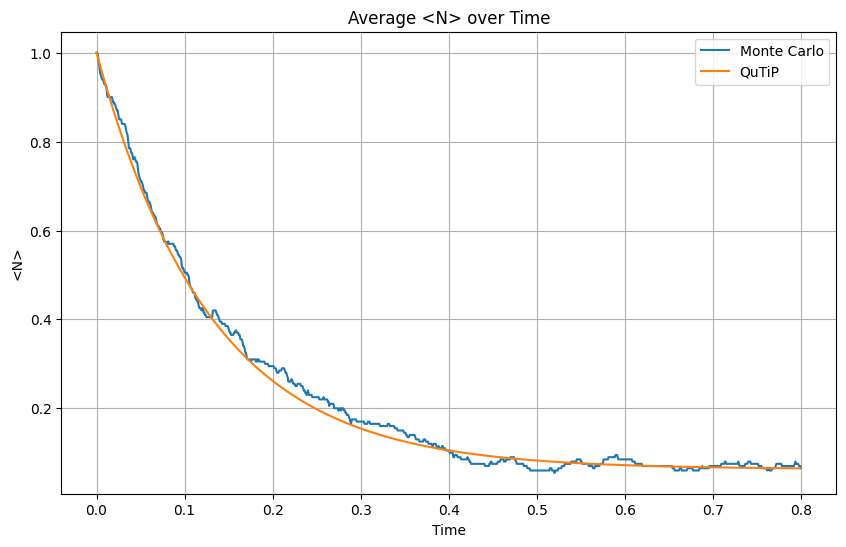

In [145]:
from qutip import mesolve, destroy, basis

aq = destroy(N)  # Destroy operator
Hq = aq.dag() * aq
c_opsq = []
c_opsq.append(np.sqrt(k * (1 + n_th)) * aq)
c_opsq.append(np.sqrt(k * n_th) * aq.dag())
psi0q = basis(N, 1)
me = mesolve(Hq, psi0q, times, c_opsq, [aq.dag() * aq])

plt.figure(figsize=(10, 6))
plt.plot(times, result)
plt.plot(times, me.expect[0])
plt.legend(['Monte Carlo', 'QuTiP'])
plt.xlabel('Time')
plt.ylabel('<N>')
plt.title('Average <N> over Time')
plt.grid(True)

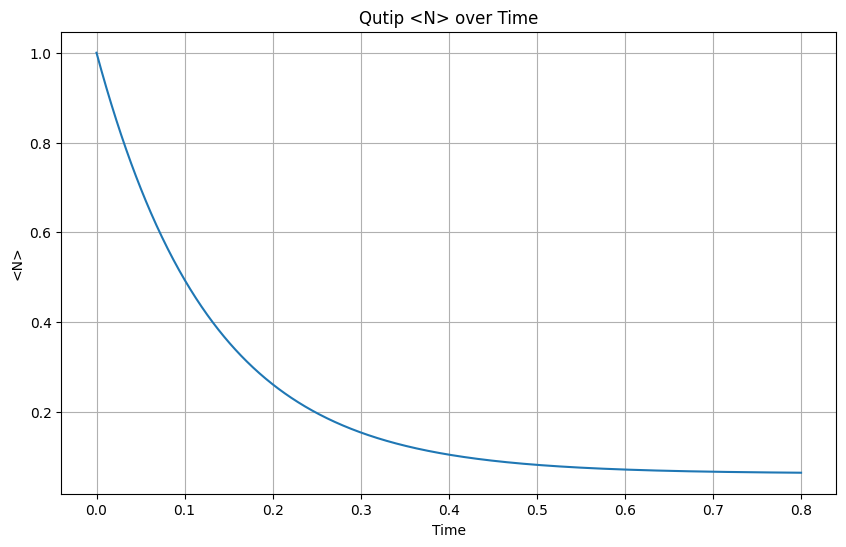

In [129]:
from qutip import mesolve, destroy, basis

a = destroy(N)  # Destroy operator
H = a.dag() * a
c_ops = []
c_ops.append(np.sqrt(k * (1 + n_th)) * a)
c_ops.append(np.sqrt(k * n_th) * a.dag())
psi0 = basis(N, 1)
me = mesolve(H, psi0, times, c_ops, [a.dag() * a])

plt.figure(figsize=(10, 6))
plt.plot(times, me.expect[0])
plt.xlabel('Time')
plt.ylabel('<N>')
plt.title('Qutip <N> over Time')
plt.grid(True)